# Visualize Cell Crops

In [1]:
import sys
sys.path.insert(1, "cell_img_visualization")

from cell_selector import (
    filter_cells_by_metadata,
    filter_by_quality_metrics,
    select_phenotype_extreme_cells,
    compute_distance_to_edge,
    select_cells_top_n,
    select_cells_percentile_random
)
from cell_cropper import (
    load_multichannel_cell_crops, 
    extract_cell_crop, 
    get_crop_coordinates_bbox,
    load_cell_image,
    validate_and_pad_crop,
    resize
)
from cell_visualizer import (
    viz_cell_grid, 
    viz_cell_single_channel,
    viz_cell_multi_channel,
    plot_cell_comparison,
)
import pickle
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from img_utils import *

## 1. Loading data

In [9]:
OUT_IMG_DIR = f"../../2.snakemake_pipeline/outputs/visualize_imgs"
# To load the dictionary and DataFrames later
with open("../../2.snakemake_pipeline/outputs/visualize_cells/batch_prof_dict.pkl", "rb") as f:
    batch_profiles = pickle.load(f)

# Load profiles
profiles = pl.concat([
    batch_profiles["2025_01_27_Batch_13"],
    batch_profiles["2025_01_28_Batch_14"]
])

profile_feats = pl.read_parquet(
    "/home/shenrunx/igvf/varchamp/2025_Pillar_VarChAMP/2_individual_assay_analyses/imaging/3_outputs/2_results_summary/f9/ref_var_sc_profiles_mad_gfp_filtered.parquet"
).unique(subset=["Metadata_CellID"], keep="first") ## ref_var_sc_profiles_mad_gfp_filtered, ref_var_sc_profiles_mad_orig

# Add distance to edge column (required for quality filtering)
profiles = profiles.with_columns(compute_distance_to_edge().alias("dist2edge"))

profiles = profiles.join(
    profile_feats,
    on="Metadata_CellID",
    how="inner",
    suffix="_feat"
).with_columns(
    (pl.col("Nuclei_Intensity_IntegratedIntensity_GFP") / pl.col("Cytoplasm_Intensity_IntegratedIntensity_GFP")).alias("Nuc2Cyto_Ratio_Integrated"),
    (pl.col("Nuclei_Intensity_MeanIntensity_GFP") / pl.col("Cytoplasm_Intensity_MeanIntensity_GFP")).alias("Nuc2Cyto_Ratio_Mean")
)

# Filter to variant and reference
var_c28r_profiles = filter_cells_by_metadata(profiles, allele='F9_Cys28Arg')
var_i316t_profiles = filter_cells_by_metadata(profiles, allele='F9_Ile316Thr')
ref_profiles = filter_cells_by_metadata(profiles, allele='F9')

# Apply quality filters
var_c28r_profiles = filter_by_quality_metrics(var_c28r_profiles, min_edge_dist=50)
var_i316t_profiles = filter_by_quality_metrics(var_i316t_profiles, min_edge_dist=50)
ref_profiles = filter_by_quality_metrics(ref_profiles, min_edge_dist=50)

In [ ]:
# # Select top 5 cells by GFP intensity
# top_cells = select_cells_top_n(
#     var_i316t_profiles,
#     feature='Cells_Intensity_IntegratedIntensity_GFP',
#     n=5,
#     direction='high'
# )

# # Extract crops with appropriate size for 20x magnification
# cell_crops = load_multichannel_cell_crops(
#     top_cells[0],
#     channels=['DAPI', 'AGP', 'Mito', 'GFP'],
#     imgs_dir="../../1.image_preprocess_qc/inputs/cpg_imgs",
#     method='bbox',
#     recenter=True,
#     target_size=128
# )

# # Visualize with single row: 4 individual channels + 1 RGB merged
# channels = ['DAPI', 'AGP', 'Mito', 'GFP']
# n_channels = len(channels)

# # Create figure with single row, 5 columns (4 channels + 1 merged)
# fig, axes = plt.subplots(1, n_channels + 1, figsize=(15, 3))

# # First 4 positions: Individual channels
# for i, channel in enumerate(channels):
#     viz_cell_single_channel(
#         cell_crops[channel],
#         channel=channel,
#         contrast_percentile=95,
#         ax=axes[i],
#         axis_off=True,
#         title=channel
#     )

# # Last position: RGB merged
# viz_cell_multi_channel(
#     cell_crops,
#     channels=channels,
#     channel_mapping='gfp_inclusive',
#     contrast_percentiles=99,
#     ax=axes[-1],  # Last axis
#     axis_off=True,
#     title='RGB Merged'
# )

# plt.tight_layout()
# # plt.savefig('cell_single_row_with_merged.png', dpi=150, bbox_inches='tight')
# plt.show()

## 2. Select cells

In [22]:
# sns.boxenplot(
#     data=pl.concat([
#         var_c28r_profiles,
#         var_i316t_profiles,
#         ref_profiles
#     ]).to_pandas(),
#     x="Metadata_gene_allele",
#     y="Cells_AreaShape_Area"
# )
# plt.show()

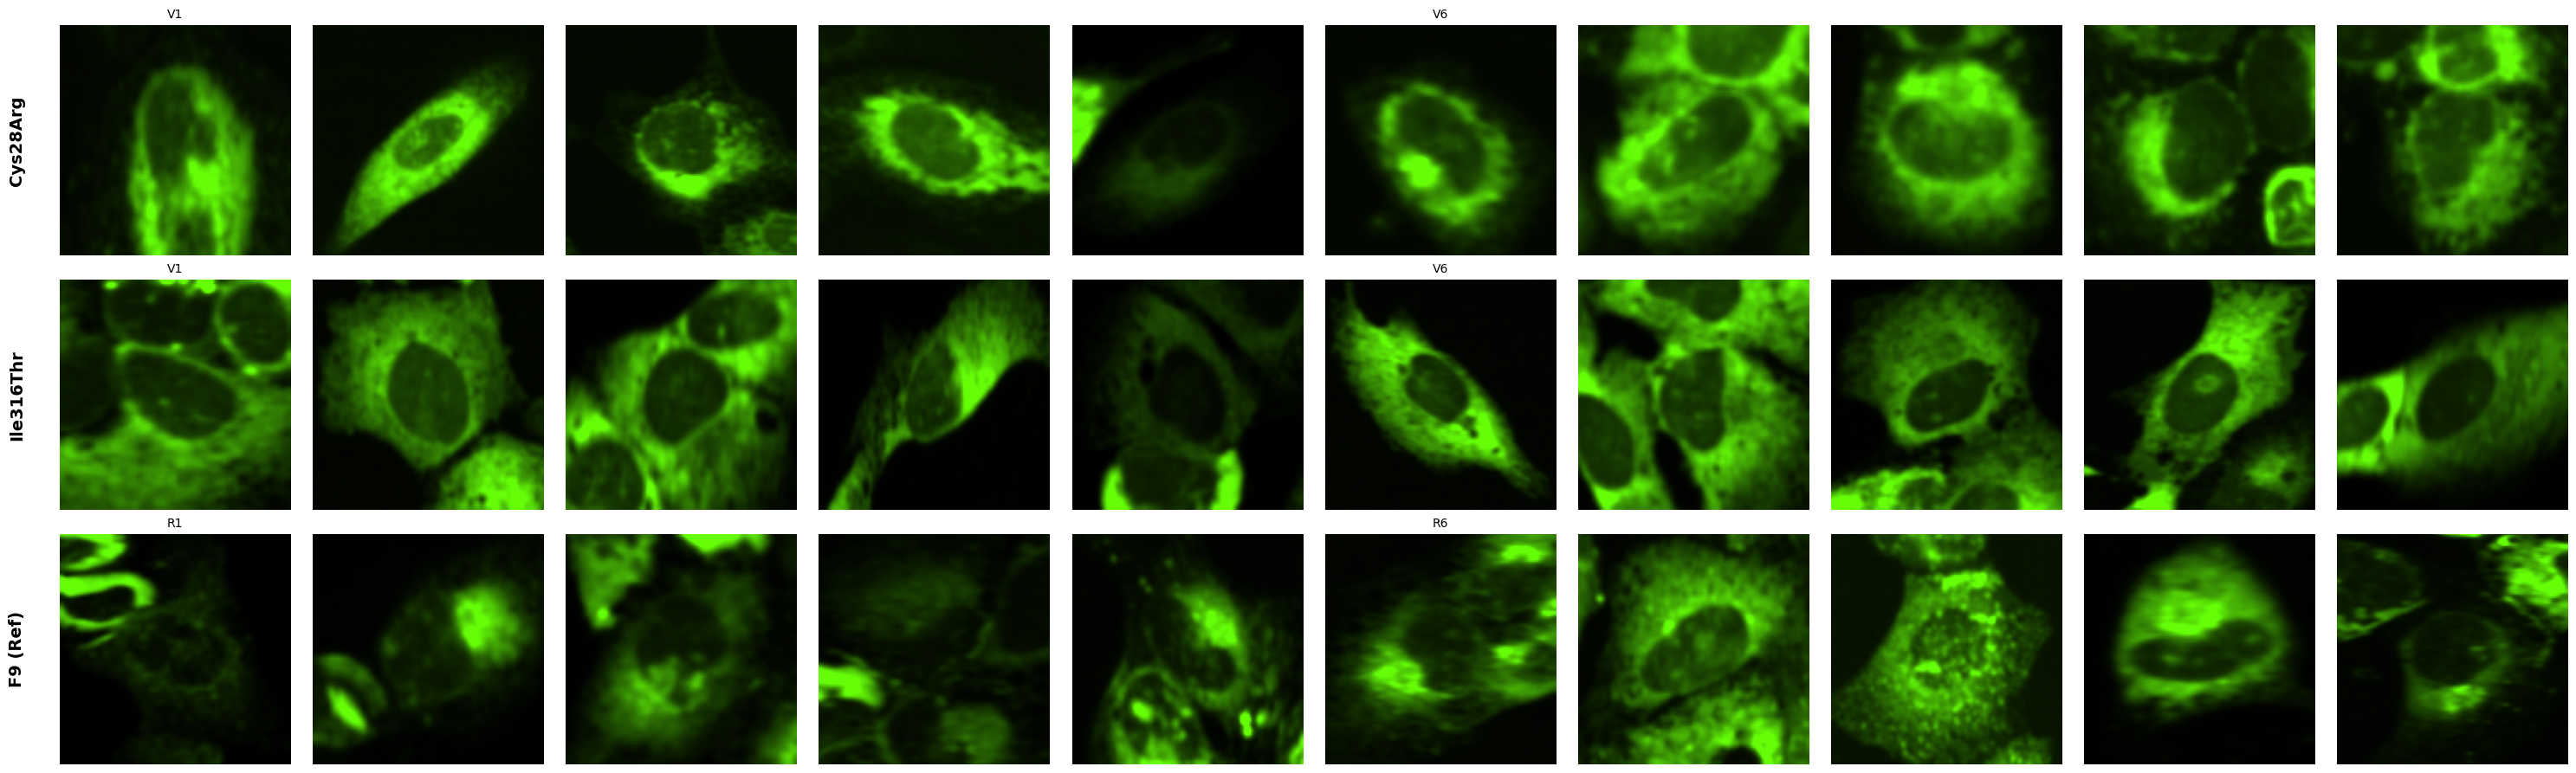

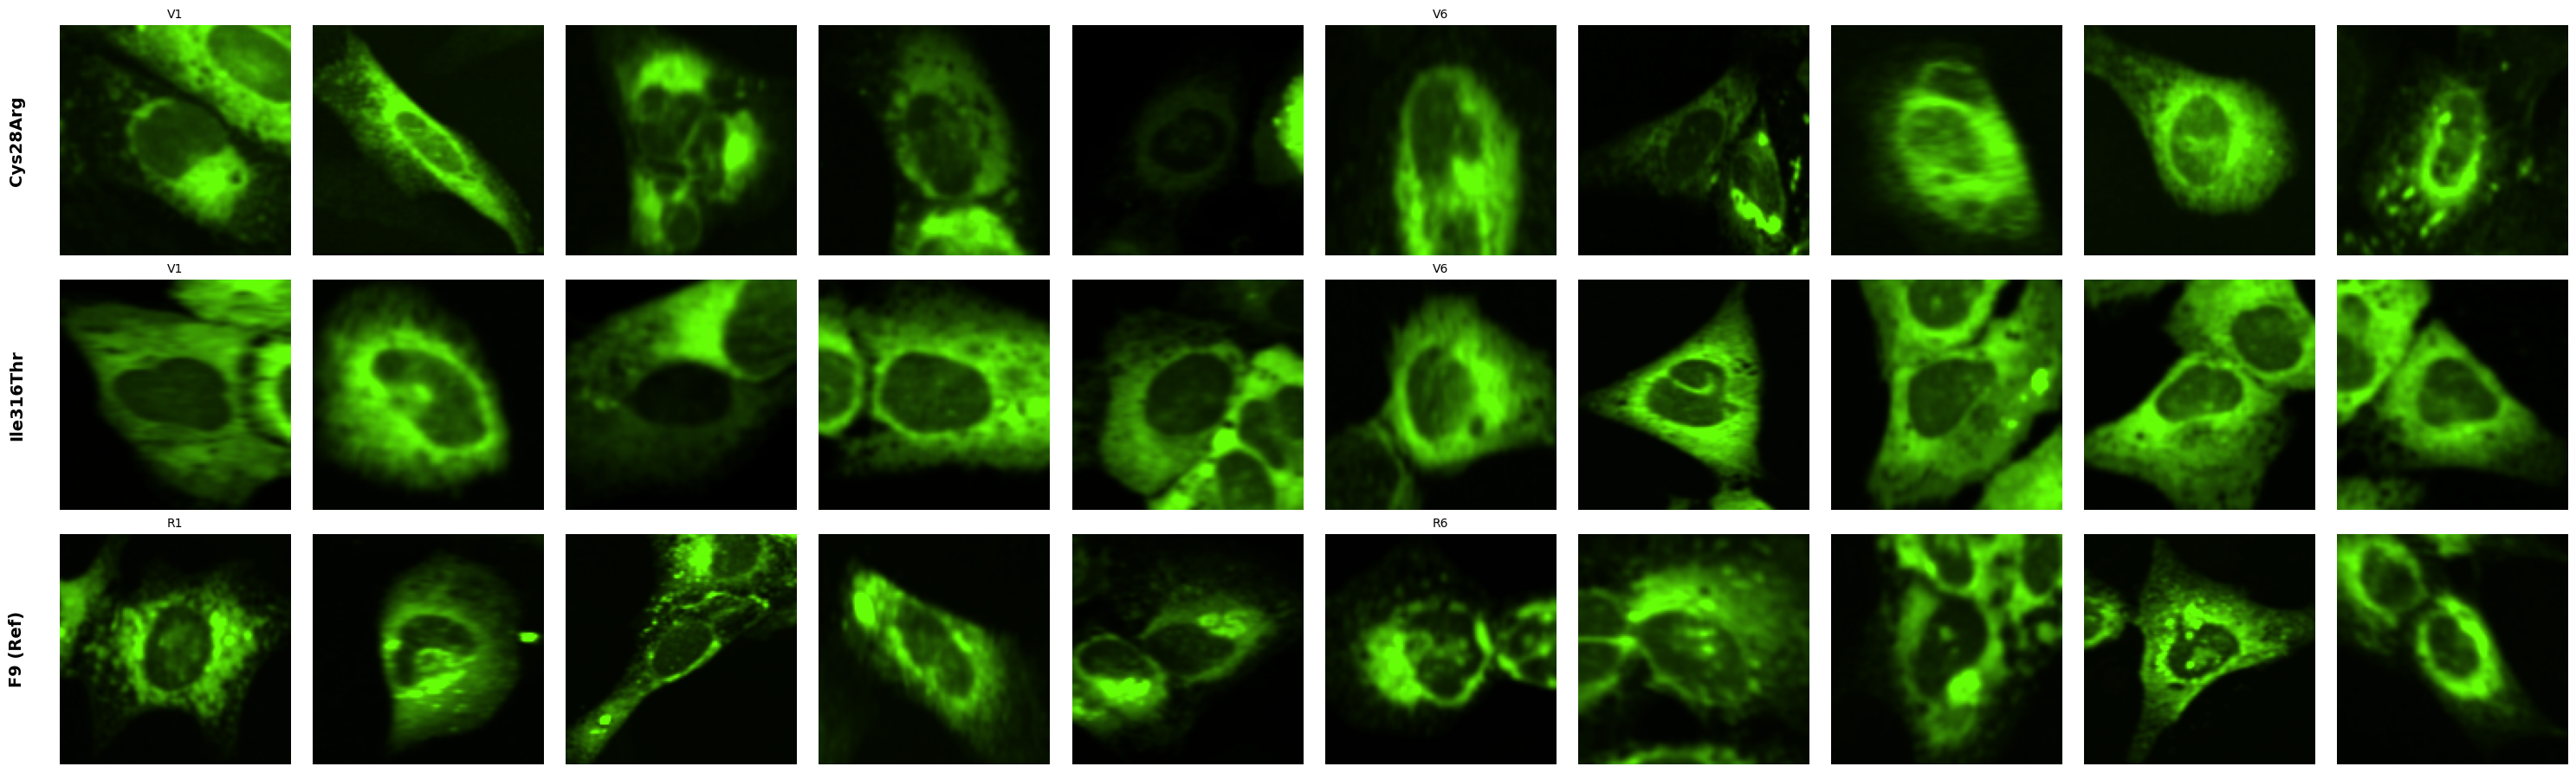

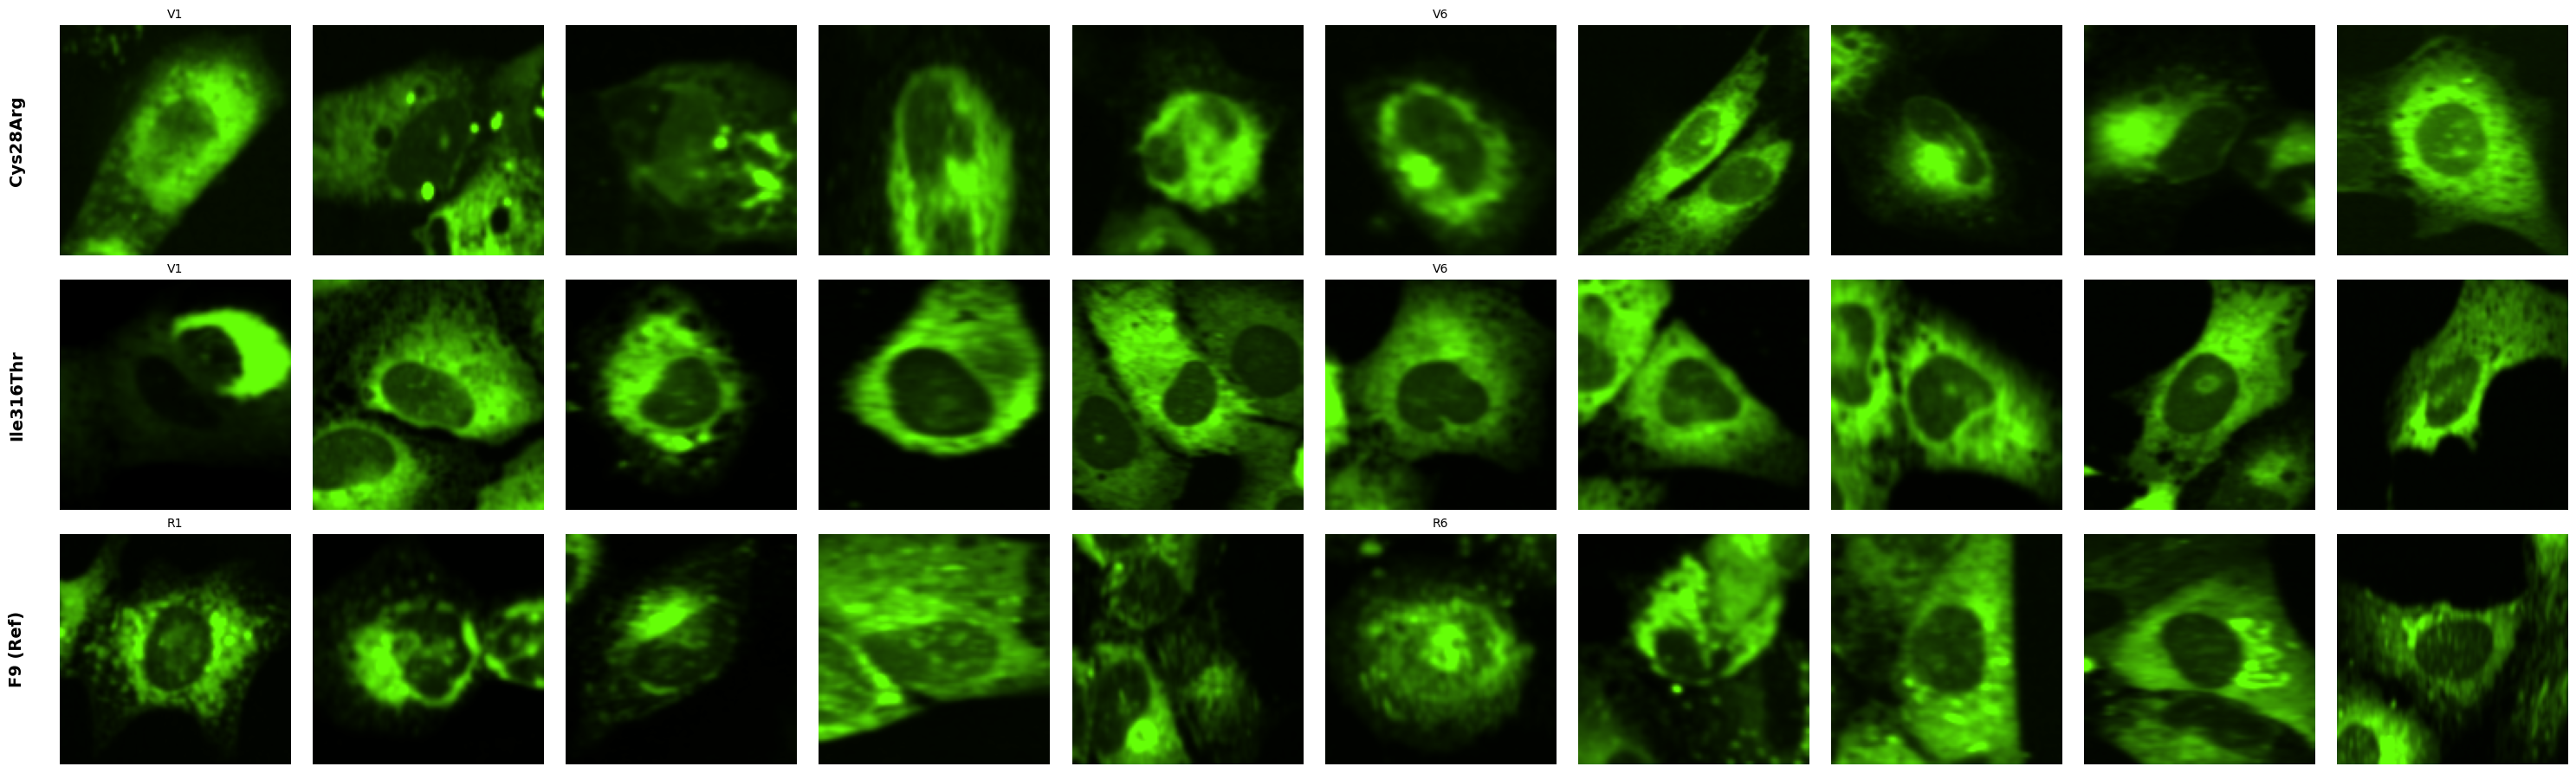

In [29]:
## Select phenotype-extreme cells - increase n to 20
# var_cells, ref_cells = select_phenotype_extreme_cells(
#     var_profiles,
#     ref_profiles.filter(
#         pl.col("Metadata_refvar_gfp_adj_classify").str.contains("F9_Cys28Arg")
#     ),
#     feature='Nuclei_Texture_DifferenceVariance_GFP_5_00_256',
#     n=20,  # Get 20 cells instead of 10
#     adaptive=True
# )
# ref_cells_filtered = filter_by_quality_metrics(
#     ref_profiles.filter(
#         pl.col("Metadata_refvar_gfp_adj_classify").str.contains("F9_Cys28Arg")
#     ),
#     min_edge_dist=50,
#     area_range=(500, 5000)
# )

# feat = "Nuc2Cyto_Ratio_Mean"  ## Nuclei_RadialDistribution_FracAtD_GFP_6of10

def plot_three_cells(feat):
    # Sample 20 cells from specific percentile ranges of the feature
    var_c28r_cells = select_cells_percentile_random(
        var_c28r_profiles.filter(
            pl.col("Cells_AreaShape_Area")>3000,
            pl.col("Cells_AreaShape_Area")<8000,
        ),
        feature=feat,
        percentile_bins=[(45, 55)],  # Top 20% of feature values
        n_per_bin=10,
        seed=0
    )
    # Sample 20 cells from specific percentile ranges of the feature
    var_i316t_cells = select_cells_percentile_random(
        var_i316t_profiles.filter(
            pl.col("Cells_AreaShape_Area")>3000,
            pl.col("Cells_AreaShape_Area")<8000,
        ),
        feature=feat,
        percentile_bins=[(45, 55)],  # Top 20% of feature values
        n_per_bin=10,
        seed=0
    )
    ref_cells = select_cells_percentile_random(
        ref_profiles.filter(
            pl.col("Cells_AreaShape_Area")>3000,
            pl.col("Cells_AreaShape_Area")<8000,
        ),
        # .filter(
        #     pl.col("Metadata_refvar_gfp_adj_classify").str.contains("F9_Cys28Arg")
        # )
        feature=feat,
        percentile_bins=[(45, 55)],  # Bottom 20% of feature values
        n_per_bin=10,
        seed=0
    )

    # Single channel: GFP only
    channels = ['GFP']
    n_cells = 10

    # Create figure: 2 rows (VAR on top, REF on bottom) x 20 columns (one per cell)
    fig, axes = plt.subplots(3, n_cells, figsize=(n_cells*3, 9))

    # Row 0: Variant cells (top 20)
    for cell_idx in range(n_cells):
        var_crops = load_multichannel_cell_crops(
            var_c28r_cells[cell_idx], channels,
            imgs_dir=TIFF_IMGS_DIR, method='bbox', target_size=128, recenter=True
        )
        viz_cell_single_channel(
            var_crops['GFP'],
            channel='GFP',
            ax=axes[0, cell_idx],
            axis_off=True,
            title=f'V{cell_idx+1}' if cell_idx % 5 == 0 else None  # Label every 5th cell
        )

    # Row 1: Reference cells (top 20)
    for cell_idx in range(n_cells):
        ref_crops = load_multichannel_cell_crops(
            var_i316t_cells[cell_idx], channels,
            imgs_dir=TIFF_IMGS_DIR, method='bbox', target_size=128, recenter=True
        )
        viz_cell_single_channel(
            ref_crops['GFP'],
            channel='GFP',
            ax=axes[1, cell_idx],
            axis_off=True,
            title=f'V{cell_idx+1}' if cell_idx % 5 == 0 else None  # Label every 5th cell
        )

    # Row 2: Reference cells (top 20)
    for cell_idx in range(n_cells):
        ref_crops = load_multichannel_cell_crops(
            ref_cells[cell_idx], channels,
            imgs_dir=TIFF_IMGS_DIR, method='bbox', target_size=128, recenter=True
        )
        viz_cell_single_channel(
            ref_crops['GFP'],
            channel='GFP',
            ax=axes[2, cell_idx],
            axis_off=True,
            title=f'R{cell_idx+1}' if cell_idx % 5 == 0 else None  # Label every 5th cell
        )

    # Add row labels
    axes[0, 0].text(-0.15, 0.5, 'Cys28Arg',
                    transform=axes[0, 0].transAxes,
                    fontsize=14, fontweight='bold',
                    rotation=90, va='center', ha='right')
    axes[1, 0].text(-0.15, 0.5, 'Ile316Thr',
                    transform=axes[1, 0].transAxes,
                    fontsize=14, fontweight='bold',
                    rotation=90, va='center', ha='right')
    axes[2, 0].text(-0.15, 0.5, 'F9 (Ref)',
                    transform=axes[2, 0].transAxes,
                    fontsize=14, fontweight='bold',
                    rotation=90, va='center', ha='right')

    plt.tight_layout()
    plt.subplots_adjust(wspace=0)
    # plt.savefig('f9_variant_vs_ref_nuclei.png', dpi=150, bbox_inches='tight')
    plt.show()

plot_three_cells("Nuc2Cyto_Ratio_Mean")
# plot_three_cells("Cells_Intensity_IntegratedIntensity_GFP")
plot_three_cells("Cytoplasm_Texture_Entropy_GFP_10_00_256")
plot_three_cells("Cytoplasm_Texture_InverseDifferenceMoment_GFP_20_01_256")

### Check cell area
### Texture features of the other channels
### 

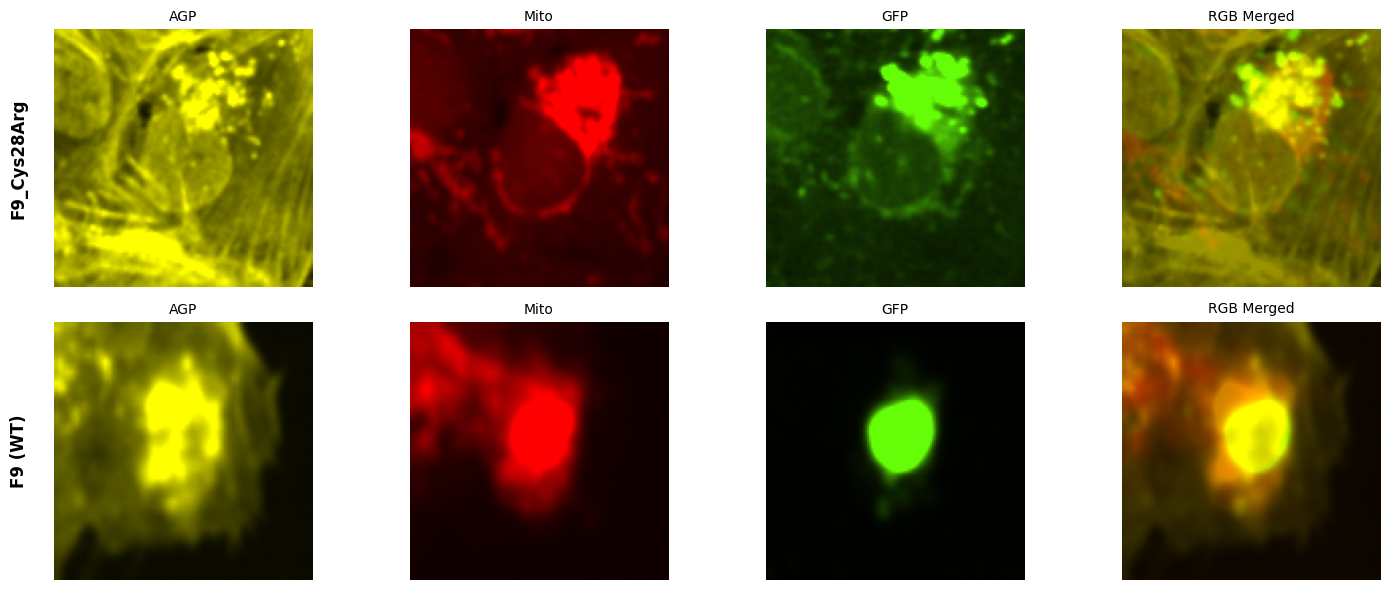

In [31]:
# Select phenotype-extreme cells
var_cells, ref_cells = select_phenotype_extreme_cells(
    var_profiles,
    ref_profiles.filter(
        pl.col("Metadata_refvar_gfp_adj_classify").str.contains("F9_Cys28Arg")
    ),
    feature='Nuclei_Correlation_K_GFP_Mito',
    n=10,
    adaptive=True
)

# Extract crops for variant and reference
channels = ['AGP', 'Mito', 'GFP']
n_channels = len(channels)

var_crops = load_multichannel_cell_crops(
    var_cells[0], channels,
    imgs_dir=TIFF_IMGS_DIR, method='bbox', target_size=128, recenter=True
)

ref_crops = load_multichannel_cell_crops(
    ref_cells[0], channels,
    imgs_dir=TIFF_IMGS_DIR, method='bbox', target_size=128, recenter=True
)

# Create figure with 2 rows (variant + reference), n_channels+1 columns (channels + merged)
fig, axes = plt.subplots(2, n_channels + 1, figsize=(15, 6))

# Row 0: Variant cell
for i, channel in enumerate(channels):
    viz_cell_single_channel(
        var_crops[channel],
        channel=channel,
        contrast_percentile=95,
        ax=axes[0, i],
        axis_off=True,
        title=channel# if i == 0 else None  # Only show title on first row
    )

# Variant RGB merged
viz_cell_multi_channel(
    var_crops,
    channels=channels,
    channel_mapping='gfp_inclusive',
    contrast_percentiles=95,
    ax=axes[0, -1],
    axis_off=True,
    title='RGB Merged'
)

# Add variant label
axes[0, 0].text(-0.1, 0.5, 'F9_Cys28Arg',
                transform=axes[0, 0].transAxes,
                fontsize=12, fontweight='bold',
                rotation=90, va='center', ha='right')

# Row 1: Reference cell
for i, channel in enumerate(channels):
    viz_cell_single_channel(
        ref_crops[channel],
        channel=channel,
        contrast_percentile=95,
        ax=axes[1, i],
        axis_off=True,
        title=channel
    )

# Reference RGB merged
viz_cell_multi_channel(
    ref_crops,
    channels=channels,
    channel_mapping='gfp_inclusive',
    contrast_percentiles=95,
    ax=axes[1, -1],
    axis_off=True,
    title='RGB Merged'
)

# Add reference label
axes[1, 0].text(-0.1, 0.5, 'F9 (WT)',
                transform=axes[1, 0].transAxes,
                fontsize=12, fontweight='bold',
                rotation=90, va='center', ha='right')

plt.tight_layout()
plt.savefig('variant_vs_ref.png', dpi=150, bbox_inches='tight')
plt.show()

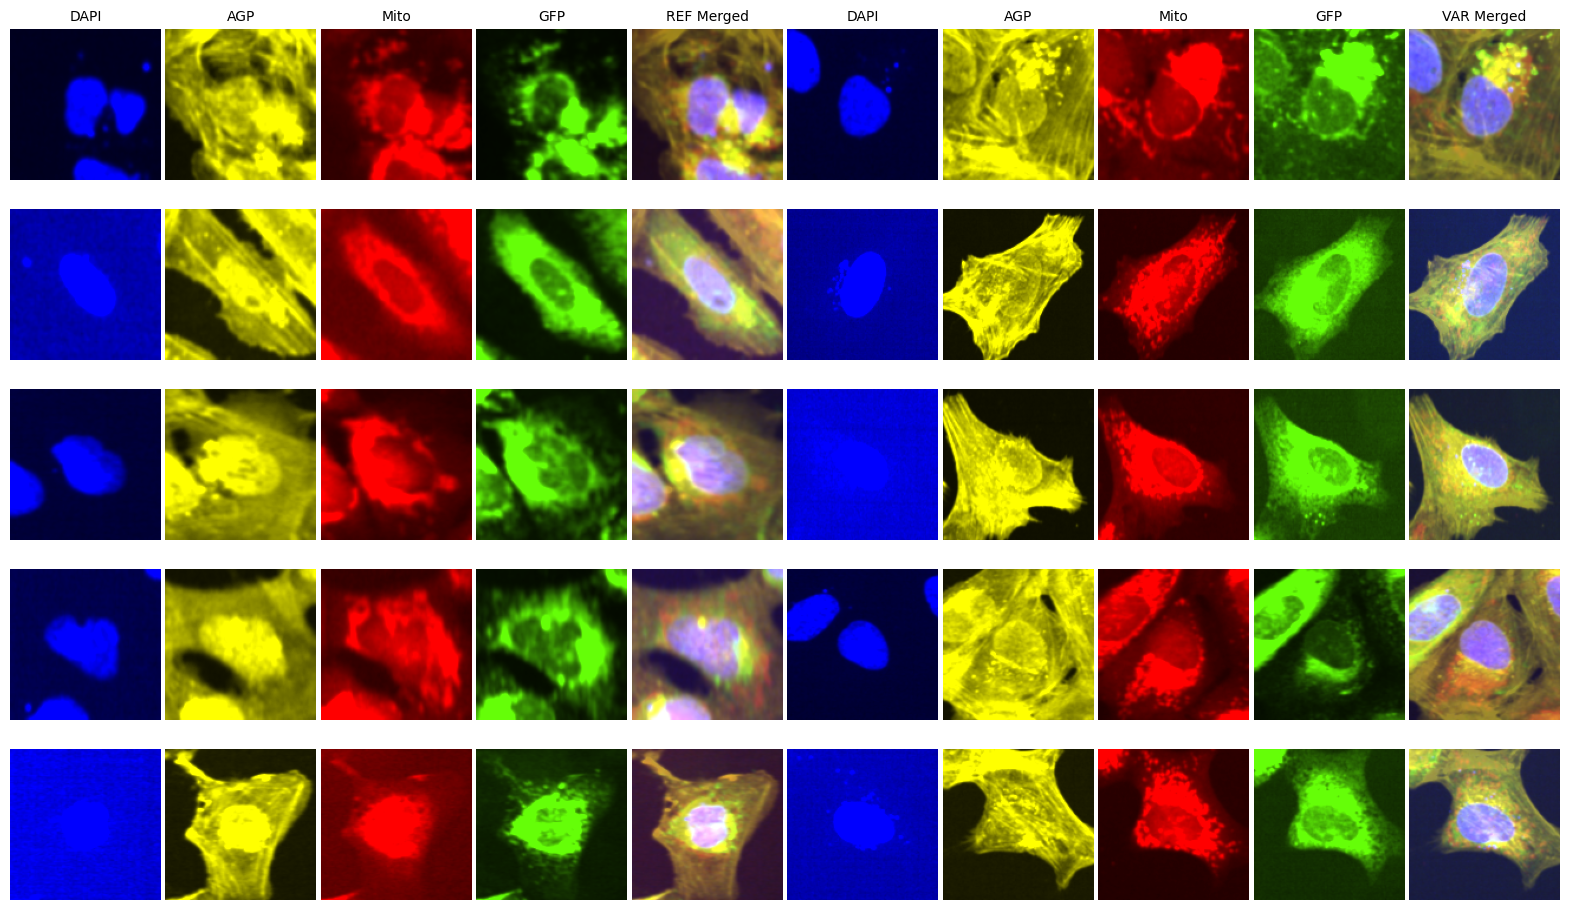

In [39]:
# Select top 5 cells from each end
n_cells_to_show = 5
channels = ["DAPI", 'AGP', 'Mito', 'GFP']
n_channels = len(channels)

# Create figure: 5 rows x 8 columns (4 for REF + 4 for VAR)
fig = plt.figure(figsize=(20, 20))
gs = gridspec.GridSpec(n_cells_to_show, 2 * (n_channels + 1),
                       hspace=-.85, wspace=0.03,top=0.98, bottom=0.02)

ref_var_dict = {
    "ref": {0: 2, 1: 3, 2: 4, 3: 5, 4: 6}
}
for cell_idx in range(n_cells_to_show):
    # Load crops
    ref_crops = load_multichannel_cell_crops(
        ref_cells[ref_var_dict["ref"][cell_idx]], channels,
        imgs_dir=TIFF_IMGS_DIR, method='bbox', target_size=128, recenter=True
    )

    var_crops = load_multichannel_cell_crops(
        var_cells[cell_idx], channels,
        imgs_dir=TIFF_IMGS_DIR, method='bbox', target_size=128, recenter=True
    )

    # REFERENCE: First 4 columns (columns 0-3)
    # Individual channels
    for i, channel in enumerate(channels):
        ax = fig.add_subplot(gs[cell_idx, i])
        viz_cell_single_channel(
            ref_crops[channel], channel,
            contrast_percentile=90, ax=ax, axis_off=True,
            title=channel if cell_idx == 0 else None
        )

    # Reference merged (column 3)
    ax = fig.add_subplot(gs[cell_idx, n_channels])
    viz_cell_multi_channel(
        ref_crops, channels, 'gfp_inclusive',
        contrast_percentiles=95, ax=ax, axis_off=True,
        title='REF Merged' if cell_idx == 0 else None
    )

    # VARIANT: Last 4 columns (columns 4-7)
    base_col = n_channels + 1
    
    # Individual channels
    for i, channel in enumerate(channels):
        ax = fig.add_subplot(gs[cell_idx, base_col + i])
        viz_cell_single_channel(
            var_crops[channel], channel,
            contrast_percentile=90, ax=ax, axis_off=True,
            title=channel if cell_idx == 0 else None
        )

    # Variant merged (column 7)
    ax = fig.add_subplot(gs[cell_idx, base_col + n_channels])
    viz_cell_multi_channel(
        var_crops, channels, 'gfp_inclusive',
        contrast_percentiles=95, ax=ax, axis_off=True,
        title='VAR Merged' if cell_idx == 0 else None
    )

# plt.tight_layout()
plt.savefig('ref_vs_var_5x8.png', dpi=150, bbox_inches='tight')
plt.show()

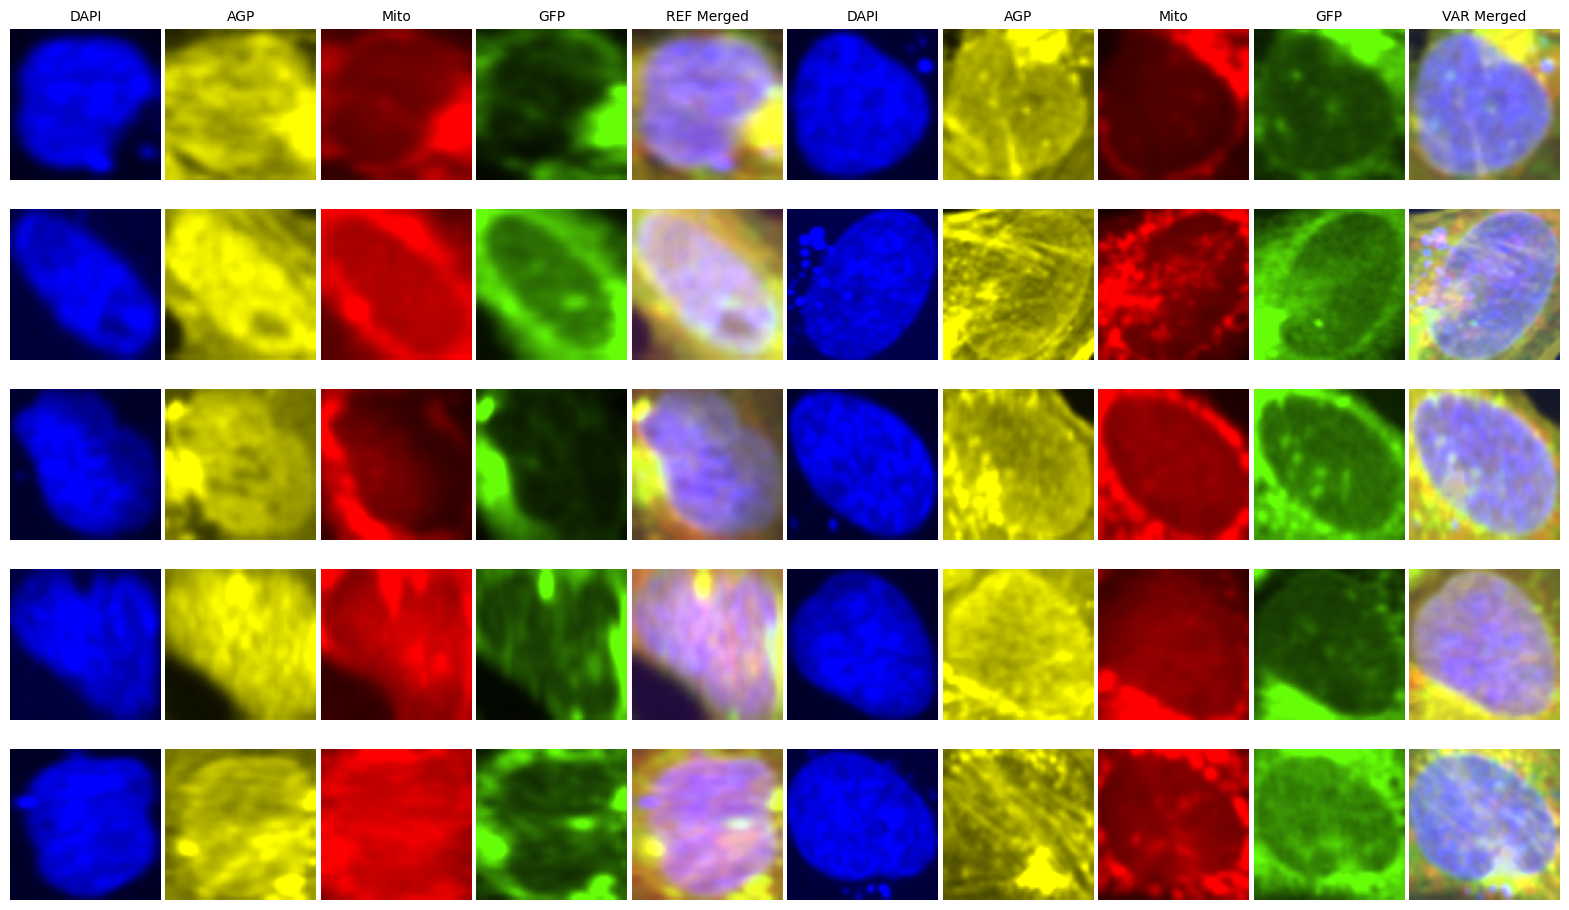

In [59]:
# MODIFIED VERSION - For Nuclei Compartment Only

size = 96
# Select top 5 cells from each end
n_cells_to_show = 5
channels = ["DAPI", 'AGP', 'Mito', 'GFP']
n_channels = len(channels)

# Create figure: 5 rows x 8 columns (4 for REF + 4 for VAR)
fig = plt.figure(figsize=(20, 20))
gs = gridspec.GridSpec(n_cells_to_show, 2 * (n_channels + 1),
                        hspace=-.85, wspace=0.03, top=0.98, bottom=0.02)

ref_var_dict = {
    "ref": {0: 2, 1: 3, 2: 4, 3: 5, 4: 6}
}

for cell_idx in range(n_cells_to_show):
    # Load crops - NUCLEI COMPARTMENT ONLY
    # Create custom cropping function that uses Nuclei bbox
    ref_crops = {}
    var_crops = {}

    for channel in channels:
        # Extract using nuclei bounding box for reference
        ref_crop = extract_cell_crop(
            ref_cells[ref_var_dict["ref"][cell_idx]],
            channel,
            imgs_dir=TIFF_IMGS_DIR,
            method='bbox',
            target_size=size,
            recenter=False  # No recentering needed - already using nuclei bbox
        )
        # Manually override to use nuclei bbox coordinates
        ref_row = ref_cells[ref_var_dict["ref"][cell_idx]]
        x_min, y_min, x_max, y_max = get_crop_coordinates_bbox(
            ref_row, recenter=False, bbox_prefix='Nuclei'
        )
        # Load and crop manually
        img = load_cell_image(ref_row, channel, TIFF_IMGS_DIR)
        ref_crop, _ = validate_and_pad_crop(img, x_min, y_min, x_max, y_max)
        if ref_crop.shape[0] > 0 and ref_crop.shape[1] > 0:
            ref_crop = resize(ref_crop, (size, size), preserve_range=True, anti_aliasing=False, order=1)
            # ref_crop = resize(ref_crop, (size, size), preserve_range=True, anti_aliasing=True)
        ref_crops[channel] = ref_crop

        # Same for variant
        var_row = var_cells[cell_idx]
        x_min, y_min, x_max, y_max = get_crop_coordinates_bbox(
            var_row, recenter=False, bbox_prefix='Nuclei'
        )
        img = load_cell_image(var_row, channel, TIFF_IMGS_DIR)
        var_crop, _ = validate_and_pad_crop(img, x_min, y_min, x_max, y_max)
        if var_crop.shape[0] > 0 and var_crop.shape[1] > 0:
            var_crop = resize(var_crop, (size, size), preserve_range=True, anti_aliasing=False, order=1)
            var_crop = resize(var_crop, (size, size), preserve_range=True, anti_aliasing=True)
        var_crops[channel] = var_crop

    # Rest of visualization code stays the same
    # REFERENCE: First 4 columns (columns 0-3)
    for i, channel in enumerate(channels):
        ax = fig.add_subplot(gs[cell_idx, i])
        viz_cell_single_channel(
            ref_crops[channel], channel,
            contrast_percentile=95, ax=ax, axis_off=True,
            title=channel if cell_idx == 0 else None
        )

    # Reference merged (column 4)
    ax = fig.add_subplot(gs[cell_idx, n_channels])
    viz_cell_multi_channel(
        ref_crops, channels, 'gfp_inclusive',
        contrast_percentiles=95, ax=ax, axis_off=True,
        title='REF Merged' if cell_idx == 0 else None
    )

    # VARIANT: Last 4 columns (columns 5-8)
    base_col = n_channels + 1

    for i, channel in enumerate(channels):
        ax = fig.add_subplot(gs[cell_idx, base_col + i])
        viz_cell_single_channel(
            var_crops[channel], channel,
            contrast_percentile=95, ax=ax, axis_off=True,
            title=channel if cell_idx == 0 else None
        )

    # Variant merged (column 8)
    ax = fig.add_subplot(gs[cell_idx, base_col + n_channels])
    viz_cell_multi_channel(
        var_crops, channels, 'gfp_inclusive',
        contrast_percentiles=95, ax=ax, axis_off=True,
        title='VAR Merged' if cell_idx == 0 else None
    )

plt.savefig('ref_vs_var_5x8_nuclei_only.png', dpi=150, bbox_inches='tight')
plt.show()